# Kinetics Project Validation Tool
## This notebook can be used to validate a model against experimental data
The following is the isothermal reaction under investigation:
$\require{mhchem}$
$$\ce{A ->[C] D + U}$$

where A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.
We can control the starting concentration of A, the concentration of C, and the reaction temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from scipy.integrate import odeint
%matplotlib inline

## Use the following cell to import tab-separated experiment data

In [2]:
filename = "data/exp1426.tsv"
exp = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['Time', 'A', 'D', 'U'])
init = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=1, names=['A', 'D', 'U', 'C', 'T'], nrows=1, usecols=range(2, 7))
t_final = exp.Time.values[-1]
t_prefinal = exp.Time.values[-2]

## We propose the following mechanism
$\require{mhchem}$
$$\ce{\alpha_1 A + \gamma C->[k_1] \beta B + \gamma C}$$

$$\ce{\alpha_2 A ->[k_2] \upsilon U}$$

$$\ce{\beta B <=>[{k_3}][{k_{-3}}] \delta D}$$


A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.

The following rate laws will be tested.

$$-r_A = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_2 C_A^{\alpha_2}$$

$$r_U = k_2 C_A^{\alpha_2}$$

$$r_B = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_{-3} C_D^{\delta} - k_3 C_B^{\beta}$$

$$r_D = k_3 C_B^\beta - k_{-3} C_D^\delta$$

Applying the pseudo steady-state hypothesis on the intermediate species B and adding the last two equations, we obtain the following relation.

$$r_D = k_1 C_A^{\alpha_1} C_C^{\gamma}.$$

Therefore,

$$-r_A = r_D + r_U$$

## Use the cell below to enter a rate law. Define all necessary constants

In [18]:
def concentrations(cA0, cC0, T, time, params):
    """"
    This function calculates the concentrations of the reacting species using a proposed rate law
    cA (mol/L) is the initial concentration of reactant A
    cC (mol/L) is the initial catalyst concentration
    T (K) is the temperature
    time (s) is the elapsed reaction time
    Return values:
    time (s) array of times at which concentrations were calculated
    cA (mol/L) array of concentrations of A during the time interval
    cD (mol/L) array of concentrations of the desired product D during the time interval
    cU (mol/L) array of concentrations of the undesired product U during the time interval
    """
    
    try:
        alpha1, alpha2, gamma, k1, k2 = params
    except:
        print("Params should contain at least 5 parameters!")
        return -1, -1, -1, -1,
    else:
        def dudt(cA):
            return k2 * cA**alpha2

        def dddt(cA):
            return k1 * cA**alpha1 * cC0**gamma
        
        def rates(parms, time):
            """
            Returns the RHS of the system of ODEs
            """
            C_A, C_D, C_U = parms
            rateD = dddt(C_A)
            rateU = dudt(C_A)
            rateA = -1. * rateD - rateU
            assert rateA.shape[0] == 1
            return (rateA, rateD, rateU)
        
        times = np.linspace(0, time, 100)
        
        result = odeint(rates, (cA0, 0., 0.), times)
        
        cA = result[:,0]
        cD = result[:,1]
        cU = result[:,2]
        
    return times, cA, cD, cU

## Integrate
Use the cell below to carry out the integration

In [55]:
alpha1 = 2.
alpha2 = 2.
gamma = 1.
k1 = 1.
k2 = .04
times, A, D, U = concentrations(init.A, init.C, init.T, t_prefinal,
                                (alpha1, alpha2, gamma, k1, k2))

## Plot
Plot the results of the calculation.

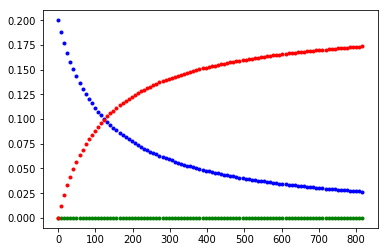

In [56]:
pl.plot(times, A, 'b.',
       times, D, 'g.',
       times, U, 'r.')

## Compare
Compare to the experimental results below.

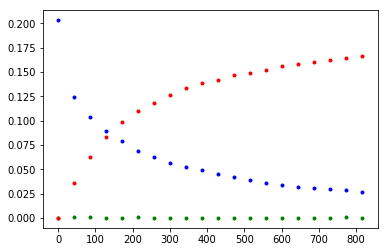

In [34]:
pl.plot(exp.Time.values[:-1], exp.A.values[:-1], 'b.',
       exp.Time.values[:-1], exp.D.values[:-1], 'g.',
       exp.Time.values[:-1], exp.U.values[:-1], 'r.')

## Parameters of interest

$\alpha_1 = 2$, $\alpha_2 = 2$, $\gamma = 1$, $k_1 = 1$, $k_2 = 0.01$

In [35]:
# use a rough parameter optimization to find k2 at the experiment temperature
# at about 125 seconds U should equal A
#from scipy.optimize import fsolve
def objective(k_2):
    t, a, d, u = concentrations(init.A, init.C, init.T, t_prefinal, (alpha1, alpha2, gamma, k1, k_2))
    diff = a[15] - u[15]
    return diff

In [43]:
guess = 0.8
max_loops = 1000000
while max_loops:
    if abs(objective(guess)) < 0.001:
        print("Found a value!")
        break
    guess-=0.01
    max_loops-=1

Found a value!


In [44]:
guess

0.039999999999999473